In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from sklearn.metrics import auc

import os
import glob
import pickle as pkl

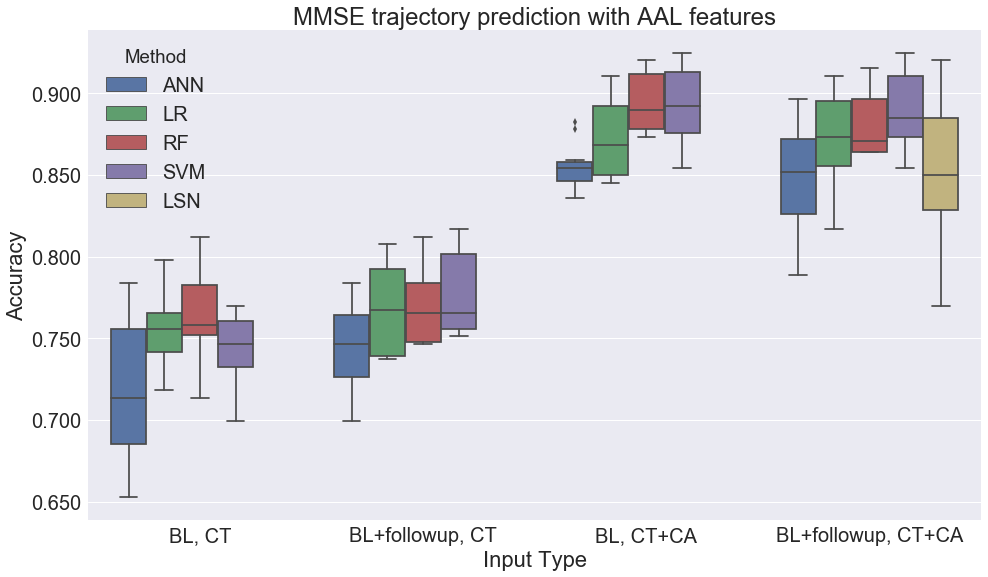

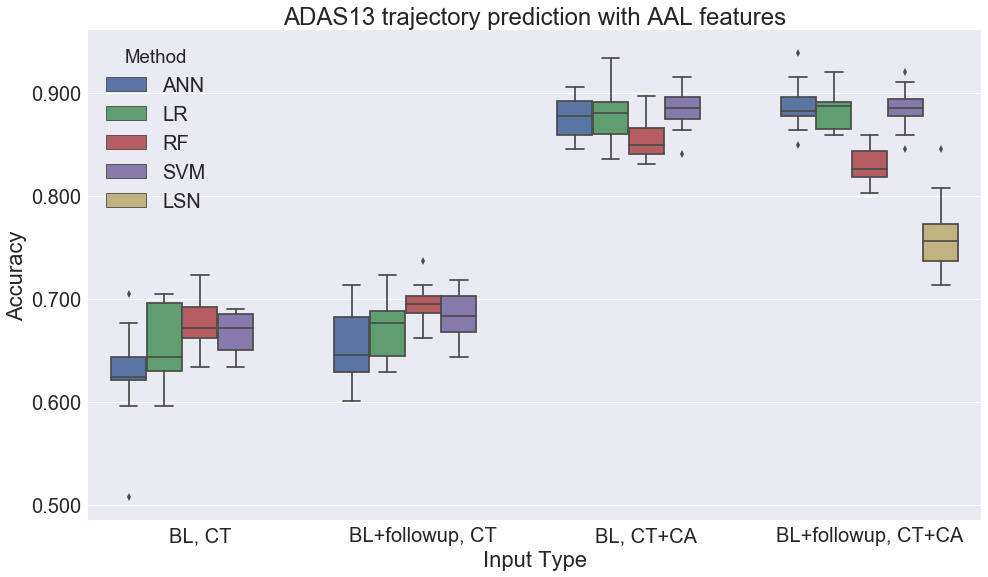

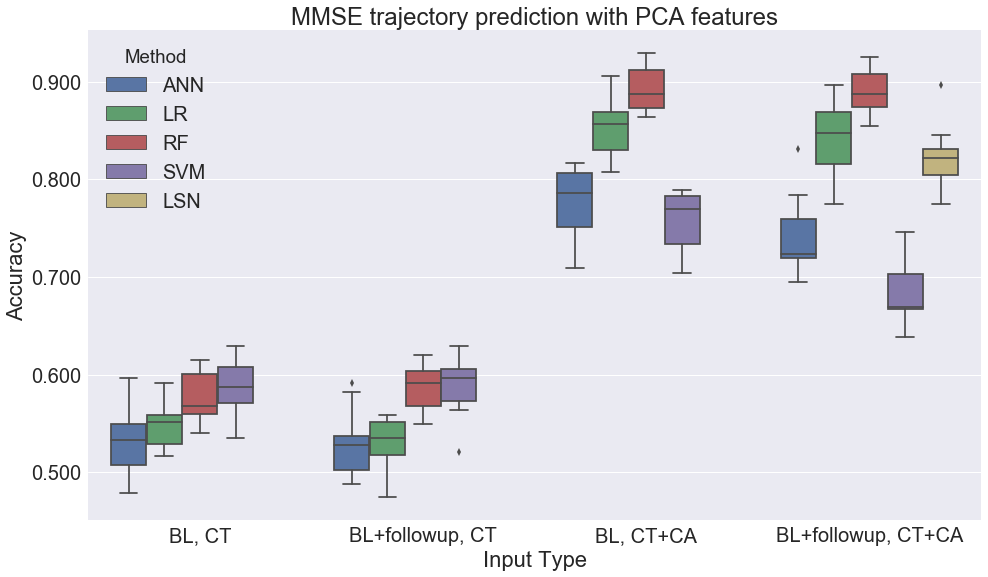

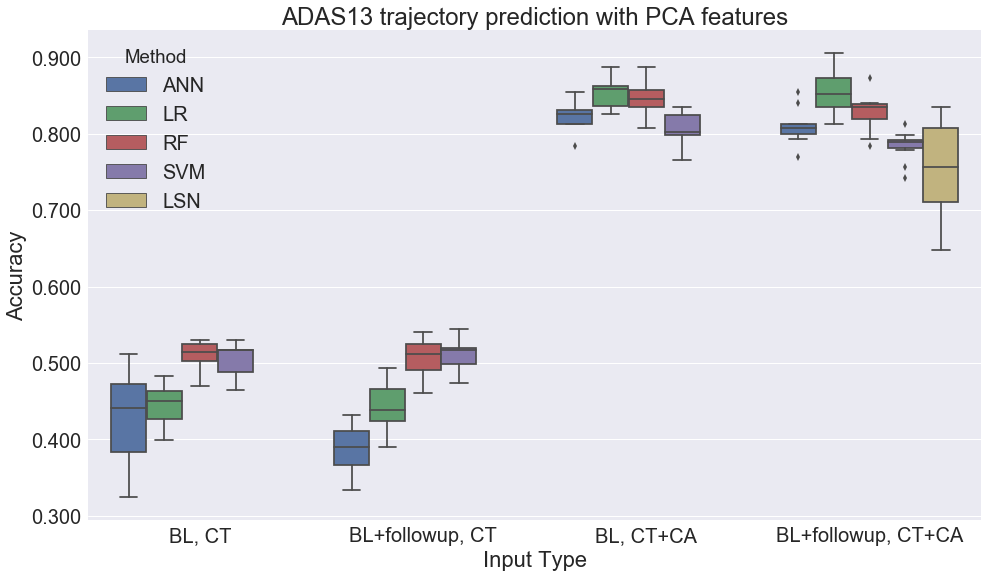

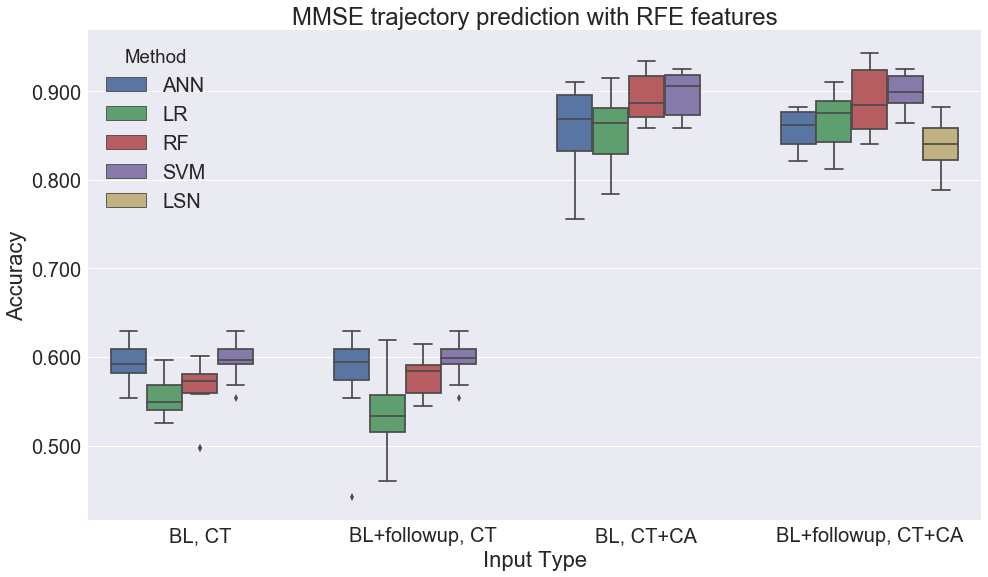

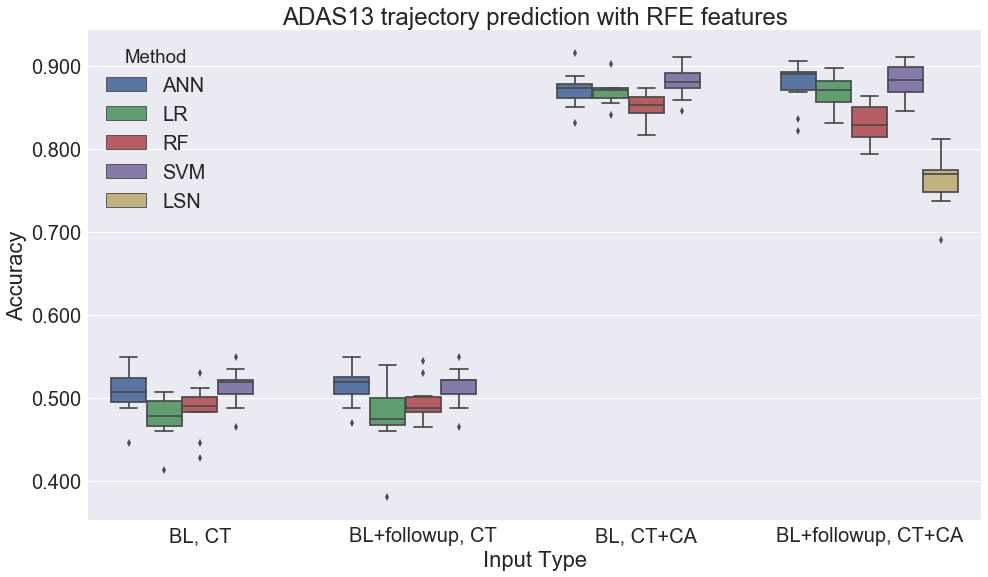

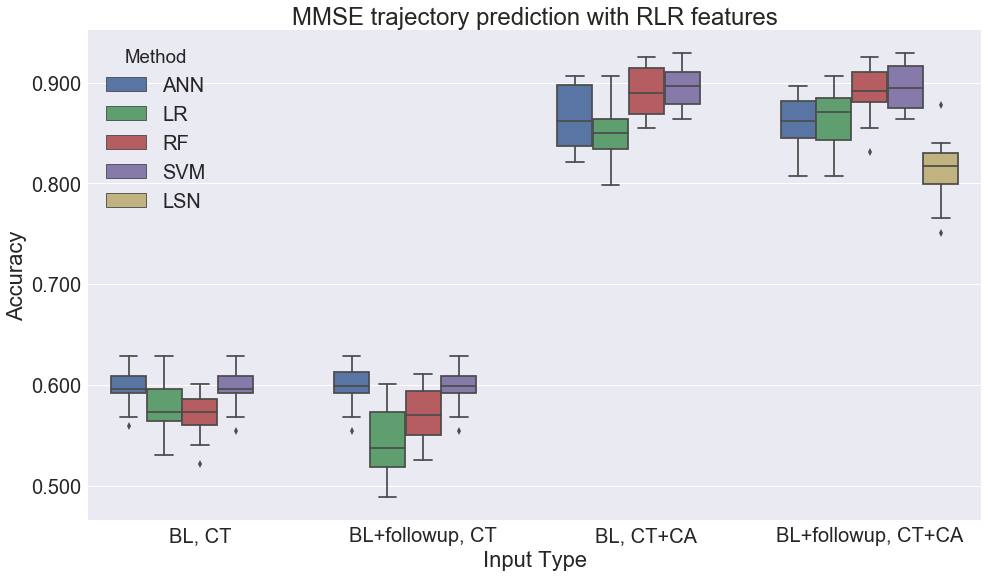

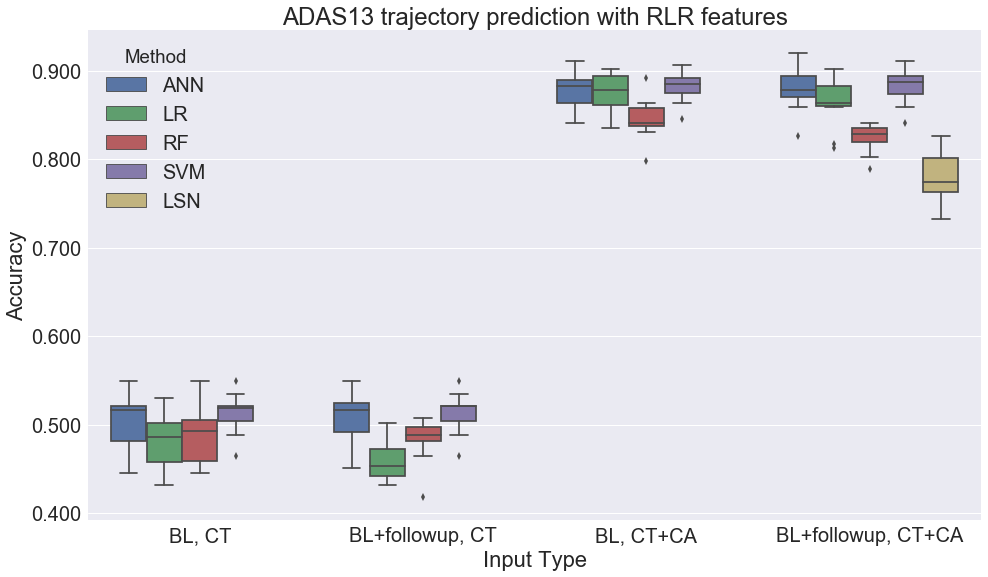

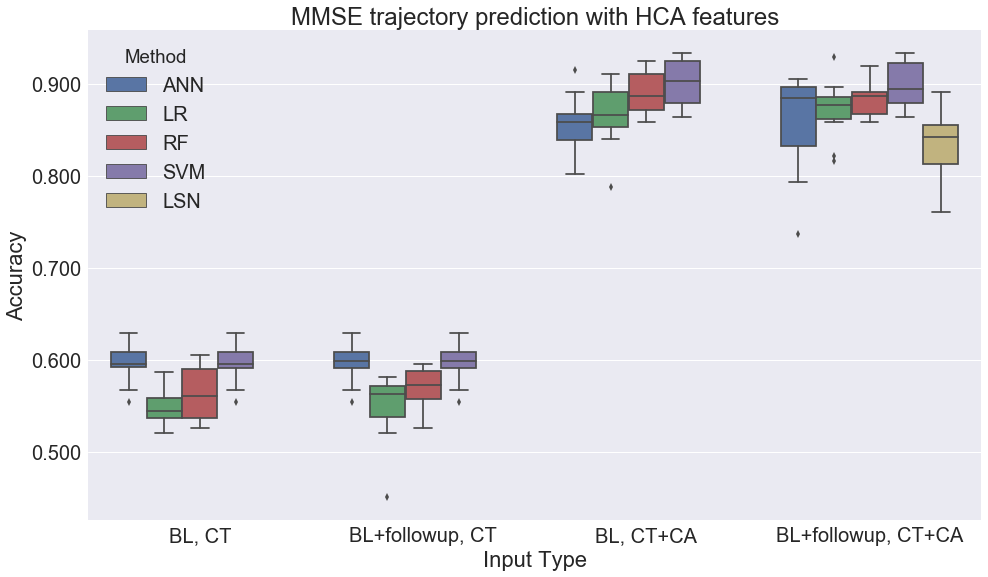

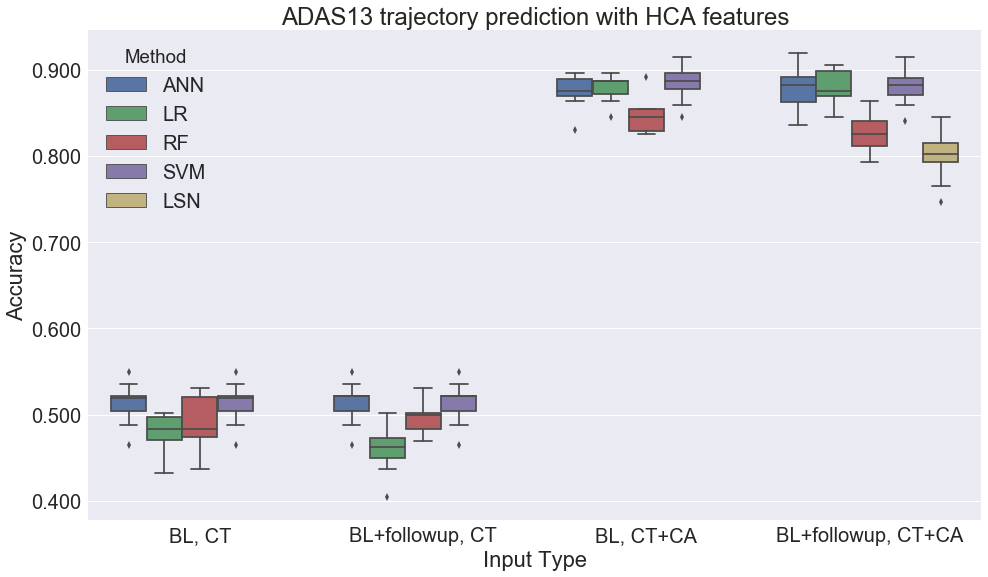

In [2]:
# Experiment Feb26 with 4 feature selection methods
df = pd.read_csv("../results/model_performance.csv")
choices = ["BL, CT", "BL+followup, CT", "BL, CT+CA","BL+followup, CT+CA"]
sns.set(font_scale=2)

# Reformat the obtained results
new_df = pd.DataFrame()
for index, row in df.iterrows():
    if row["Method"] != "LSN" and row["NoClinical"] != "OnlyClinical":
        if row["NoClinical"] == "True" and row["NoFollowup"]:
            condition = "BL, CT"
        elif row["NoClinical"] == "True":
            condition = "BL+followup, CT"
        elif row["NoFollowup"]:
            condition = "BL, CT+CA"
        else:
            condition = "BL+followup, CT+CA"
        method = row["Method"]
        featuretype = row["FeatureType"]
        trajectory = row["Trajectory"]
        
        for i in range(10):
            accuracy = row["Accuracy{}".format(i)]
            new_row = {"Accuracy": accuracy, 
                       "Method": method,
                       "Input Type": condition,
                       "FeatureType": featuretype,
                       "Trajectory": trajectory}
            new_df = new_df.append(new_row, ignore_index=True)

# Append the results with the LSN method
for index, row in df.iterrows():
    if row["Method"] == "LSN":
        condition = "BL+followup, CT+CA"
        method = row["Method"]
        featuretype = row["FeatureType"]
        trajectory = row["Trajectory"]
        
        for i in range(10):
            accuracy = row["Accuracy{}".format(i)]
            new_row = {"Accuracy": accuracy, 
                       "Method": method,
                       "Input Type": condition,
                       "FeatureType": featuretype,
                       "Trajectory": trajectory}
            new_df = new_df.append(new_row, ignore_index=True)
            
# Append the results with clinical attributes only
for index, row in df.iterrows():
    if row["NoClinical"] == "OnlyClinical":
        if row["NoFollowup"]:
            condition = "BL, CA"
        else:
            condition = "BL+followup, CA"
        method = row["Method"]
        featuretype = row["FeatureType"]
        trajectory = row["Trajectory"]
        
        for i in range(10):
            accuracy = row["Accuracy{}".format(i)]
            new_row = {"Accuracy": accuracy, 
                       "Method": method,
                       "Input Type": condition,
                       "FeatureType": featuretype,
                       "Trajectory": trajectory}
            new_df = new_df.append(new_row, ignore_index=True)

# Look through the experimental conditions
for f in ["AAL", "PCA", "RFE", "RLR", "HCA"]:
    for t in ["MMSE", "ADAS13"]:
        plt.figure(figsize=(16,9))
        cur_df = new_df.loc[(new_df["Trajectory"] == t) & (new_df["FeatureType"] == f)]
        ax = sns.boxplot(x="Input Type", y="Accuracy", hue="Method", data=cur_df, order=choices)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
        plt.title("{} trajectory prediction with {} features".format(t, f))
        plt.savefig("../plots/Exp_Feb26/{}_{}_acc_boxplot.png".format(t, f))

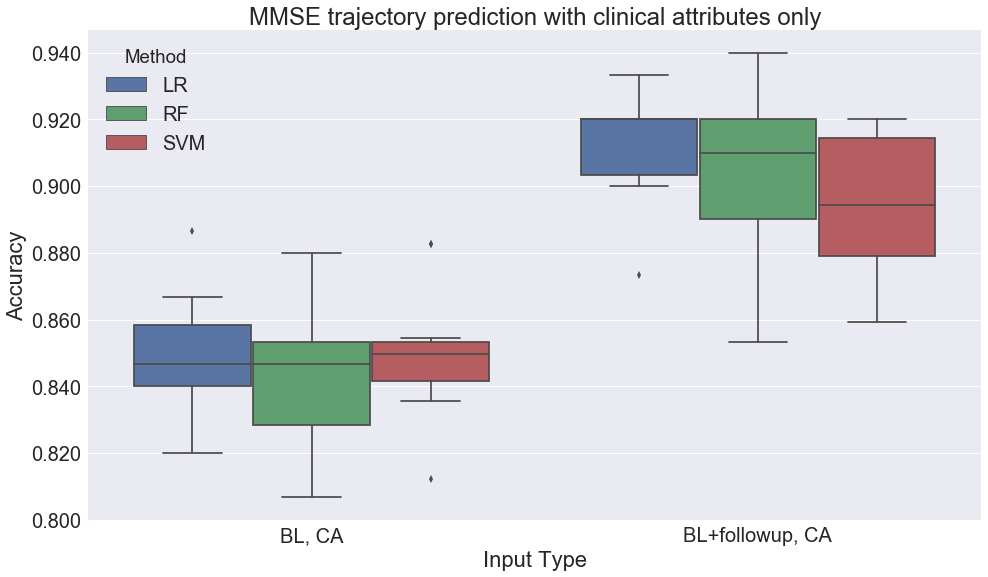

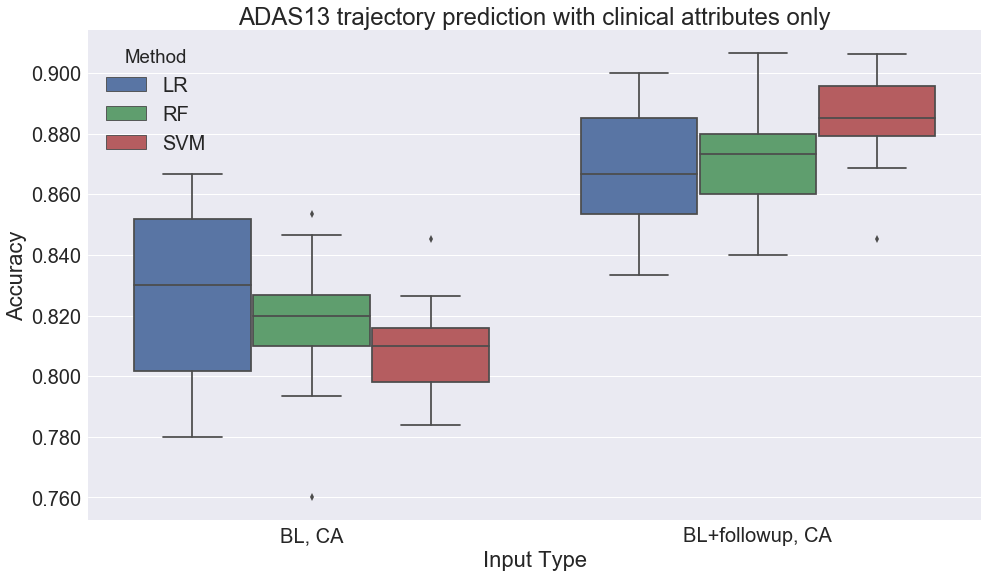

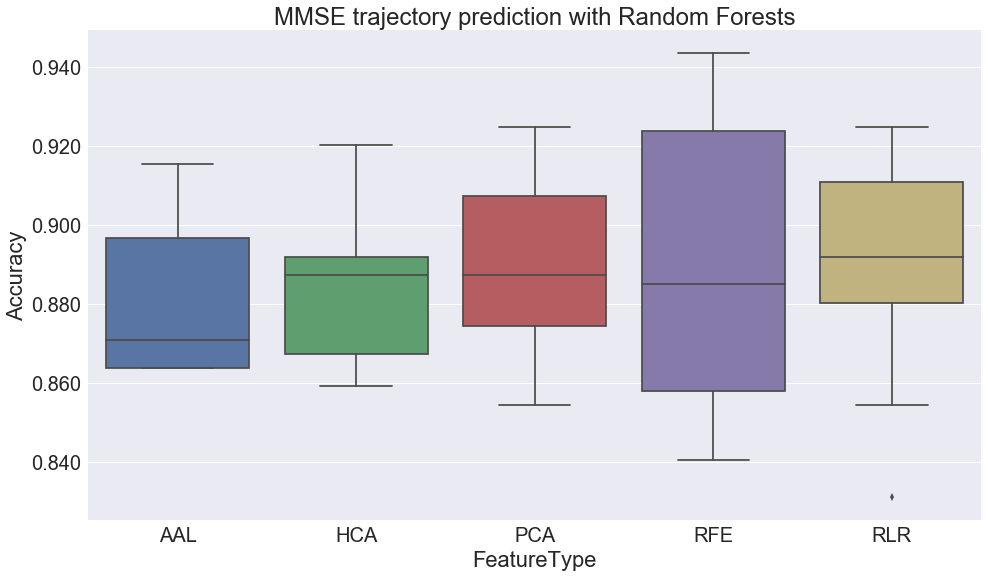

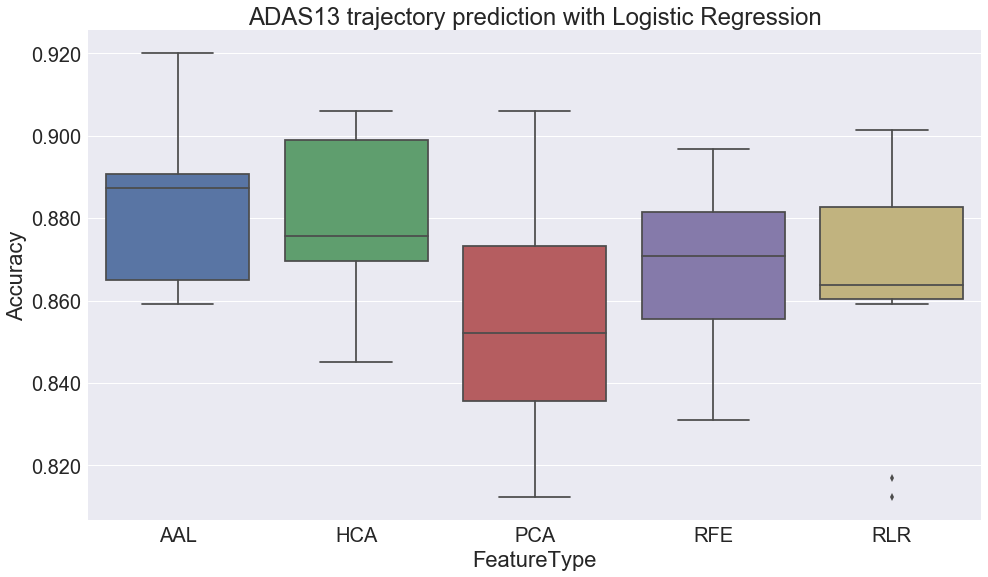

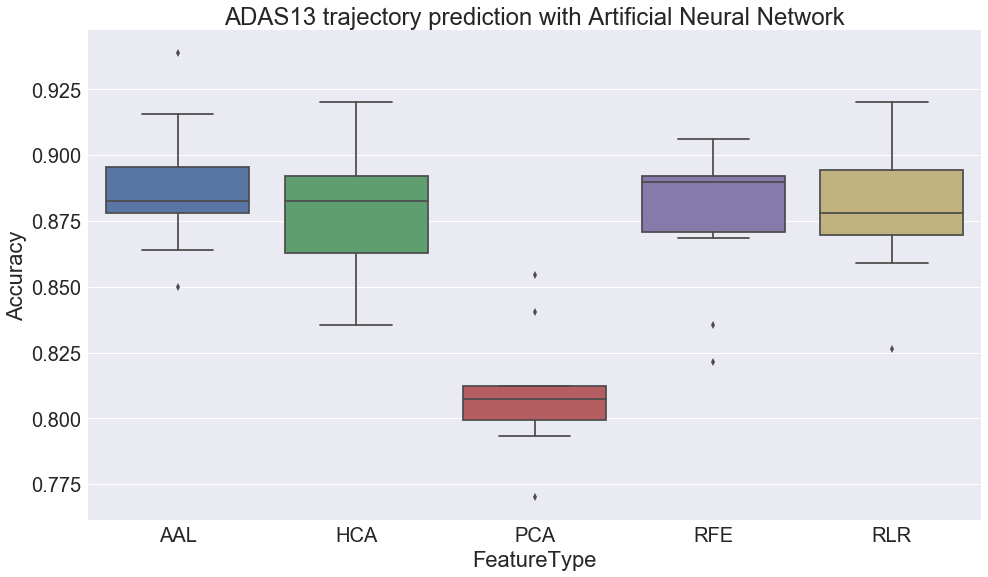

In [3]:
# Plot the results with clinical attributes only
for t in ["MMSE", "ADAS13"]:
    plt.figure(figsize=(16,9))
    cur_df = new_df.loc[(new_df["Trajectory"] == t) & (new_df["FeatureType"] == "None")]
    ax = sns.boxplot(x="Input Type", y="Accuracy", hue="Method", data=cur_df, 
                     order=["BL, CA", "BL+followup, CA"])
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    plt.title("{} trajectory prediction with clinical attributes only".format(t))
    plt.savefig("../plots/Exp_Feb26/{}_CA-only_acc_boxplot.png".format(t))
    
# Plot the RF results for MMSE trajectory prediction
plt.figure(figsize=(16,9))
cur_df = new_df.loc[(new_df["Trajectory"] == "MMSE") & (new_df["Method"] == "RF") & 
                    (new_df["Input Type"] == "BL+followup, CT+CA")]
ax = sns.boxplot(x="FeatureType", y="Accuracy", data=cur_df)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
plt.title("MMSE trajectory prediction with Random Forests")
plt.savefig("../plots/Exp_Feb26/MMSE_RF_best_method.png")

# Plot the LR results for ADAS13 trajectory prediction
plt.figure(figsize=(16,9))
cur_df = new_df.loc[(new_df["Trajectory"] == "ADAS13") & (new_df["Method"] == "LR") & 
                    (new_df["Input Type"] == "BL+followup, CT+CA")]
ax = sns.boxplot(x="FeatureType", y="Accuracy", data=cur_df)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
plt.title("ADAS13 trajectory prediction with Logistic Regression")
plt.savefig("../plots/Exp_Feb26/ADAS13_LR_best_method.png")

# Plot the ANN results for ADAS13 trajectory prediction
plt.figure(figsize=(16,9))
cur_df = new_df.loc[(new_df["Trajectory"] == "ADAS13") & (new_df["Method"] == "ANN") & 
                    (new_df["Input Type"] == "BL+followup, CT+CA")]
ax = sns.boxplot(x="FeatureType", y="Accuracy", data=cur_df)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
plt.title("ADAS13 trajectory prediction with Artificial Neural Network")
plt.savefig("../plots/Exp_Feb26/ADAS13_ANN_best_method.png")

/opt/quarantine/anaconda/5.1.0-python3/install/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


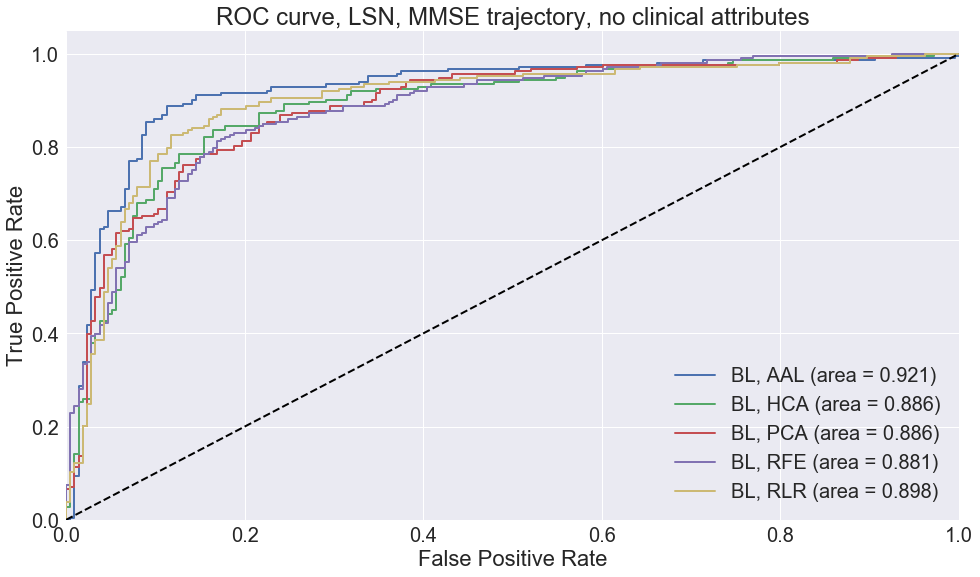

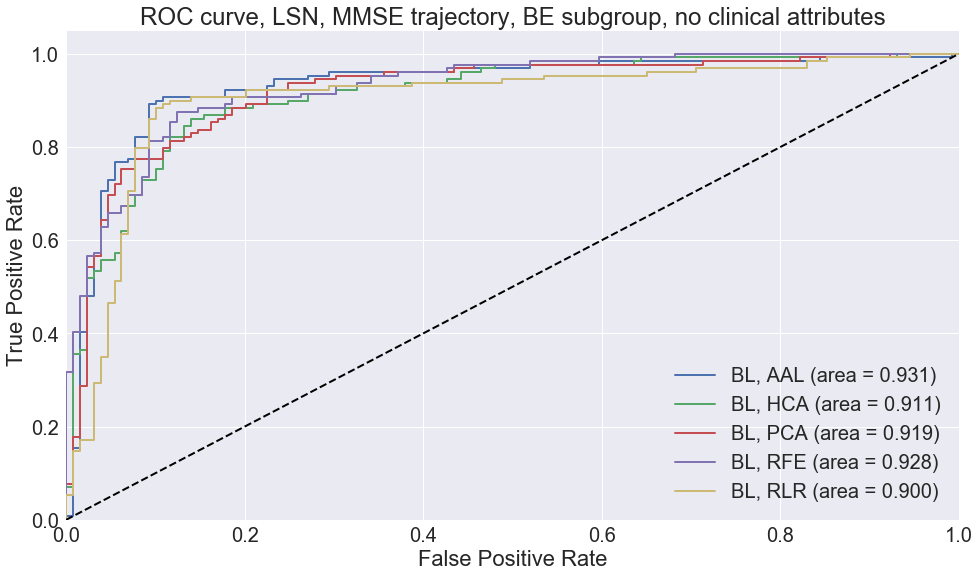

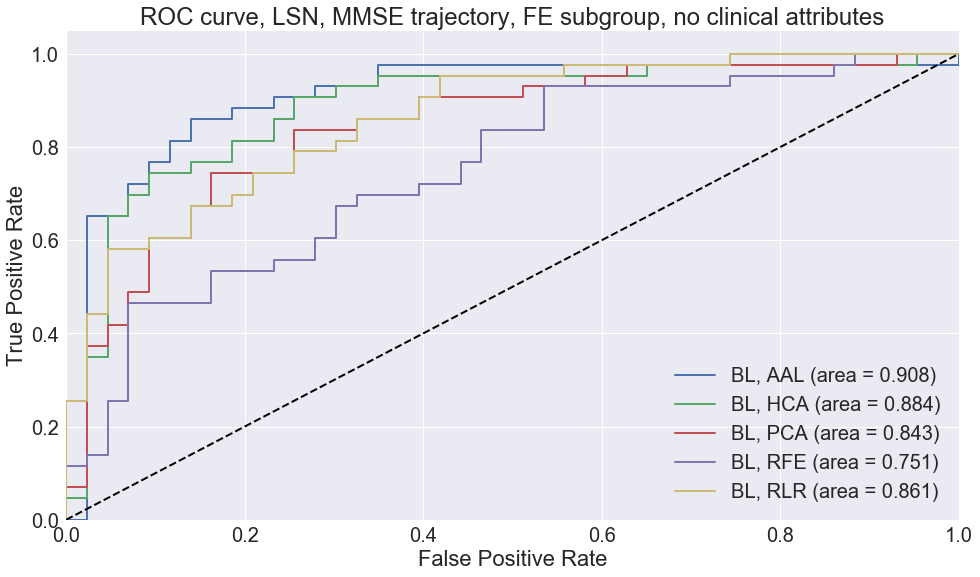

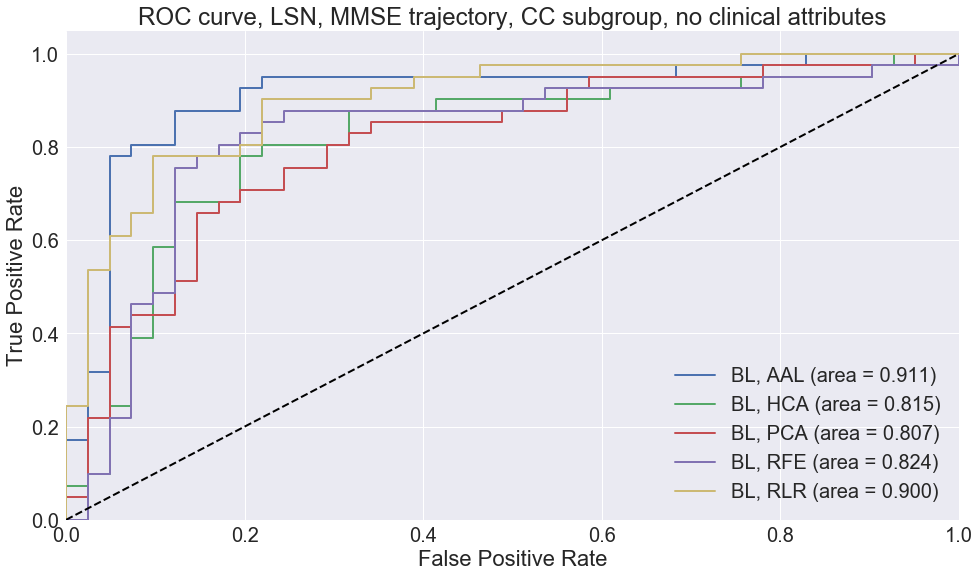

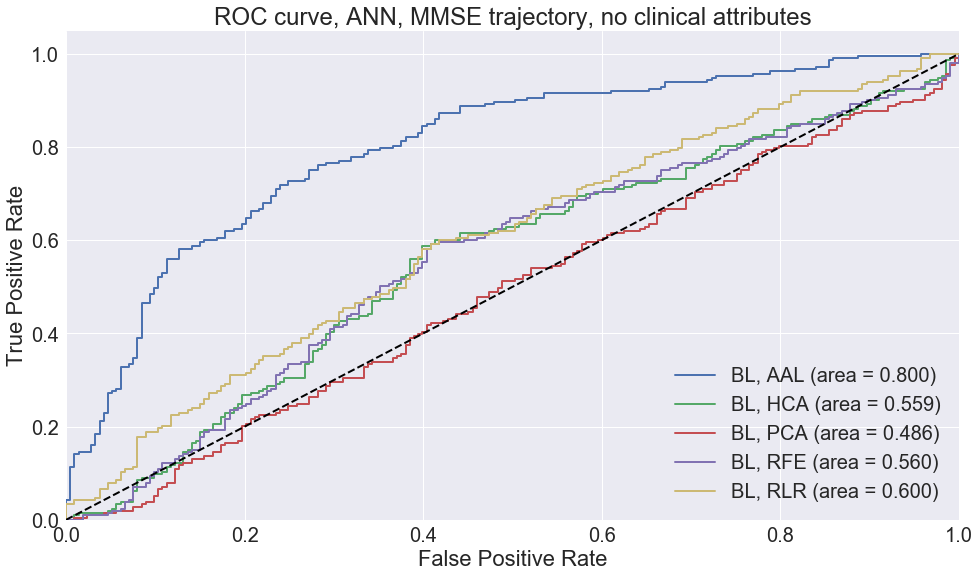

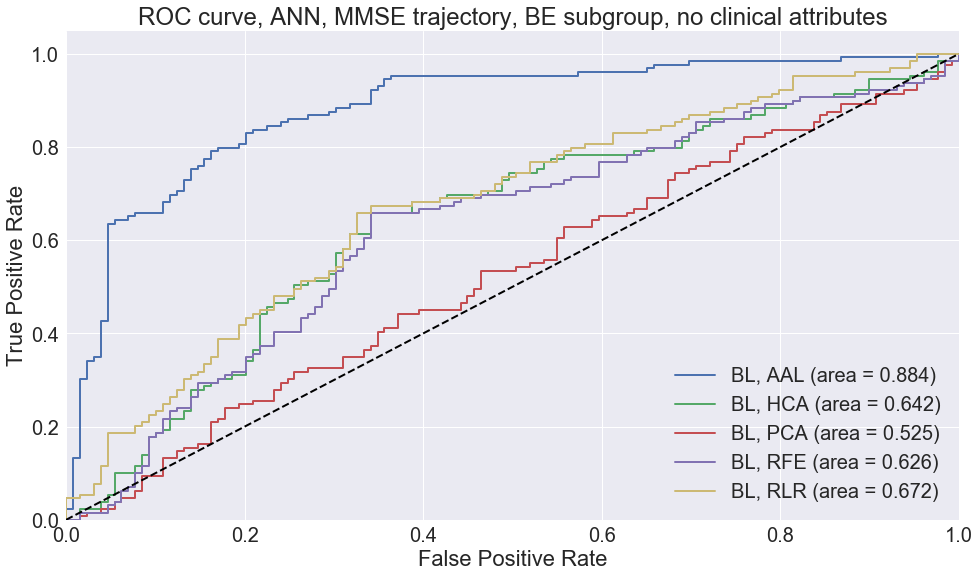

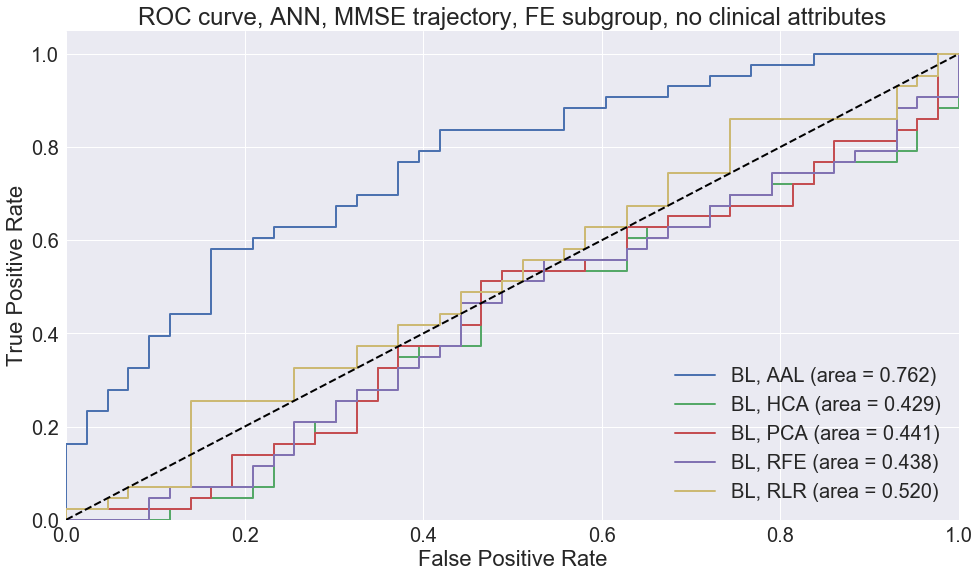

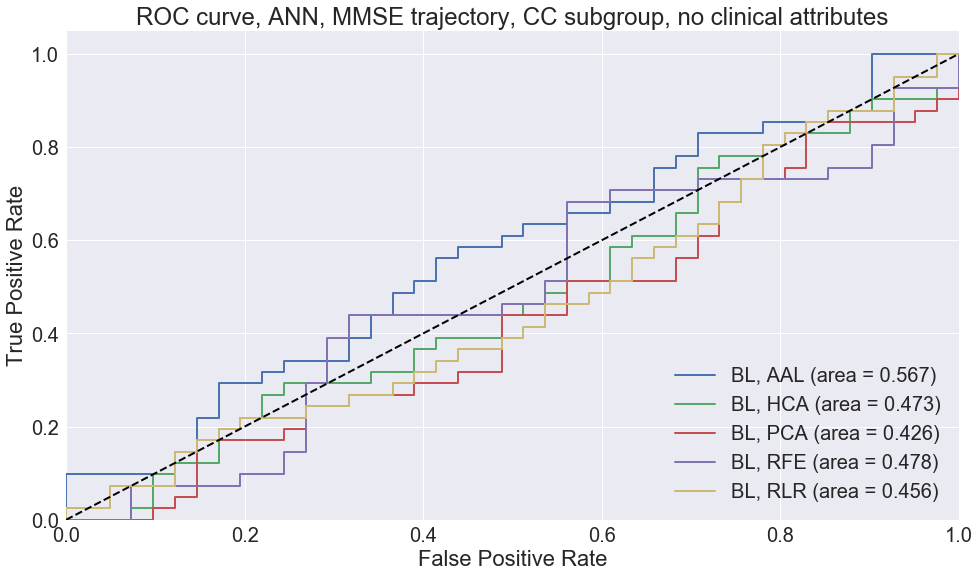

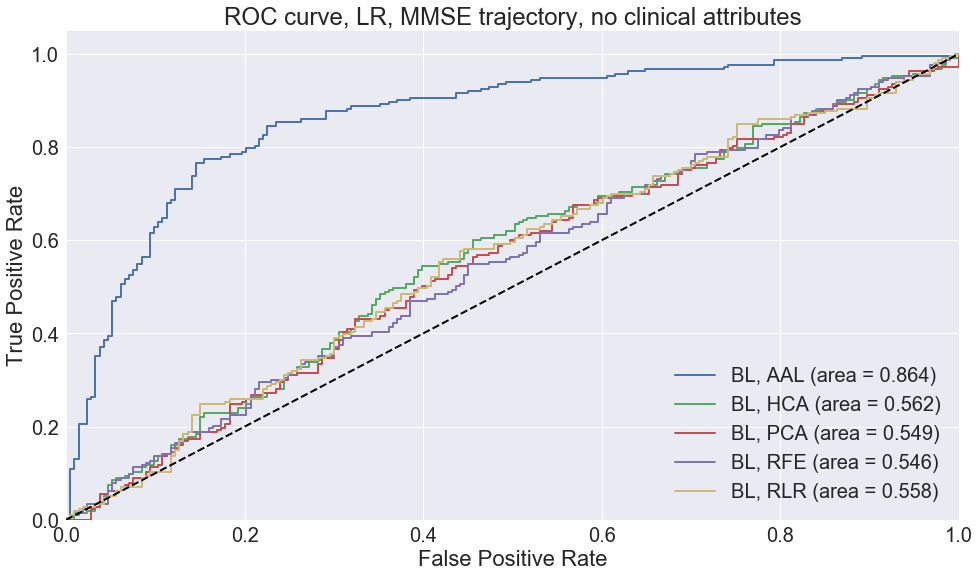

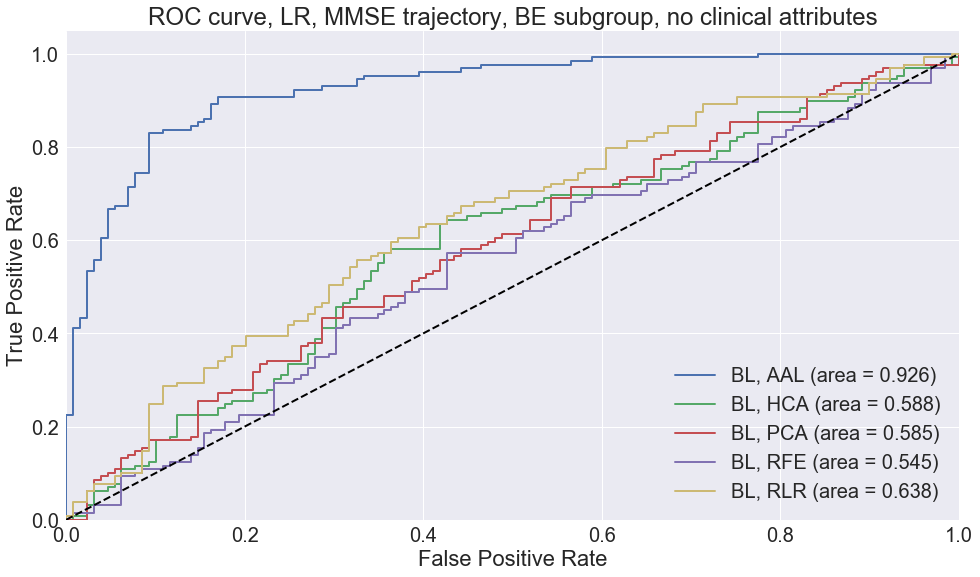

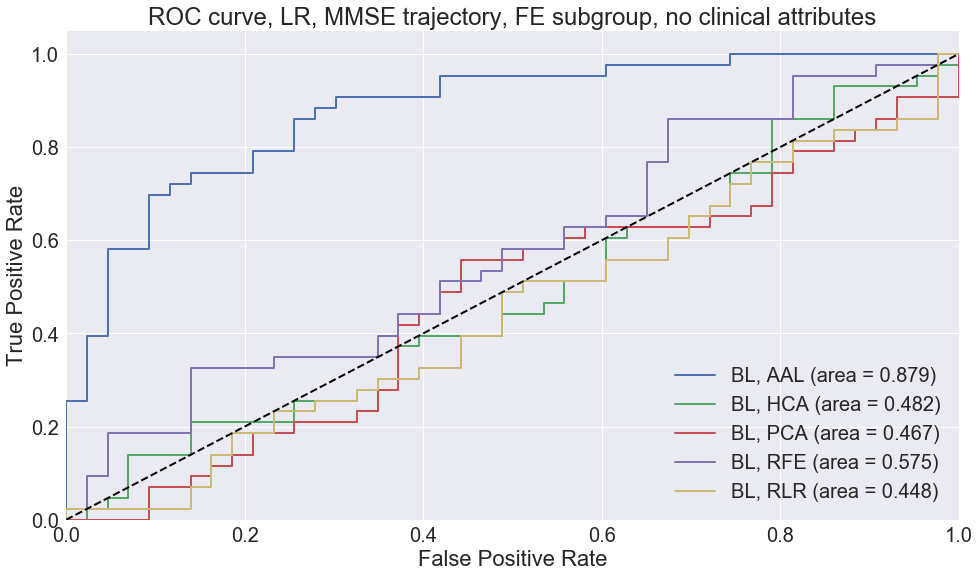

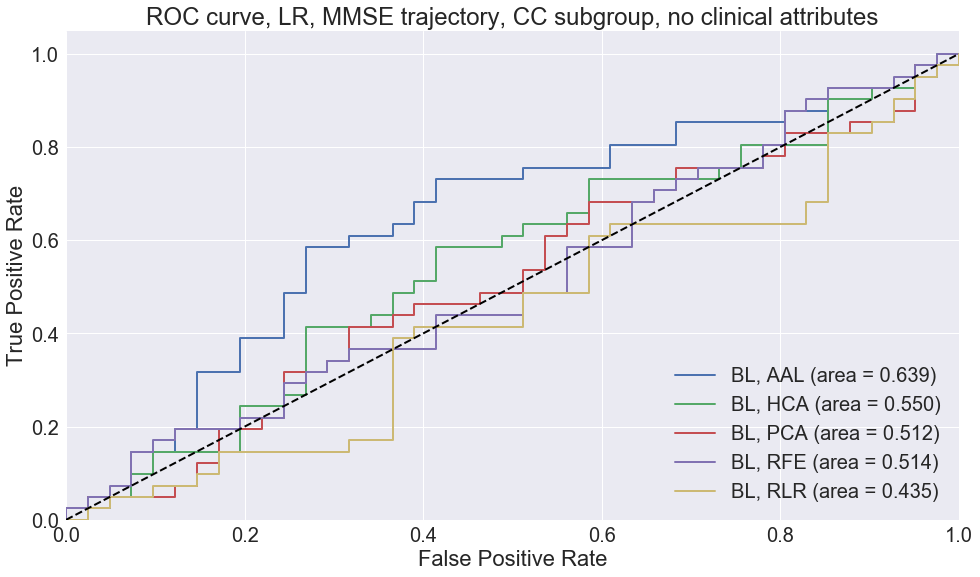

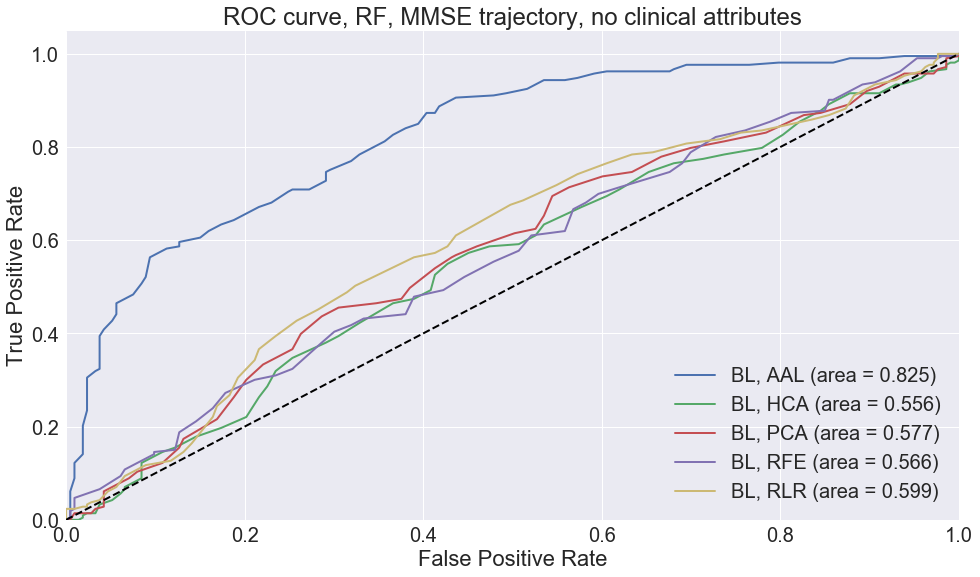

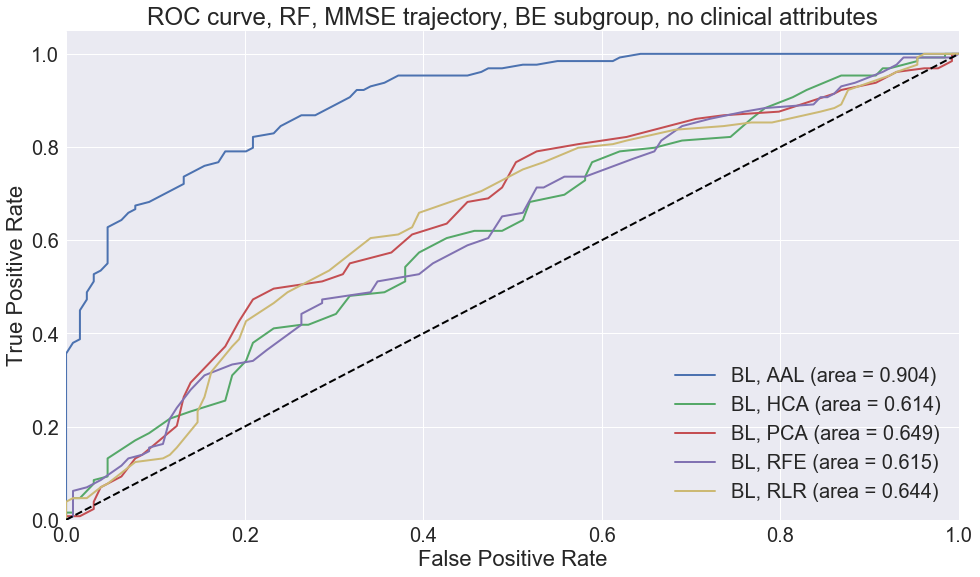

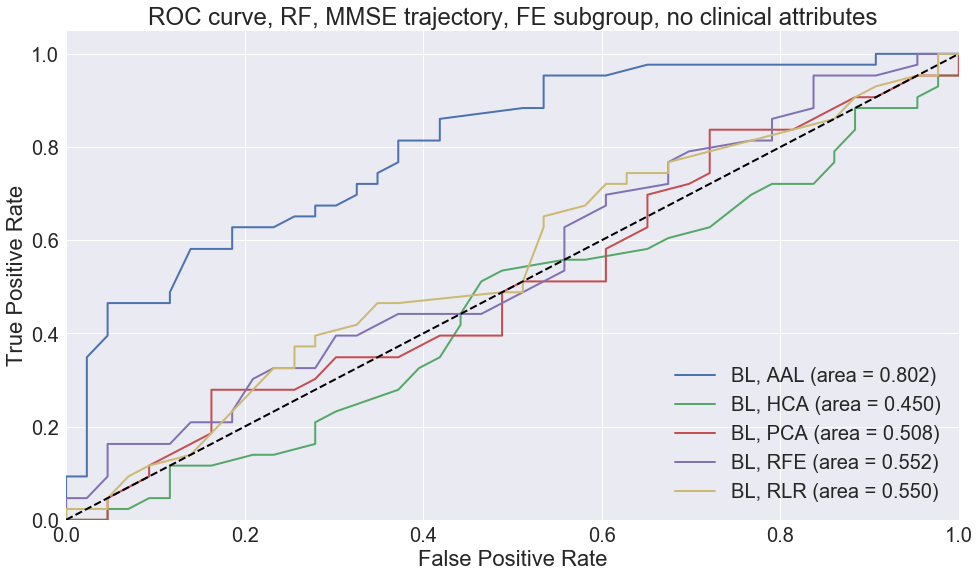

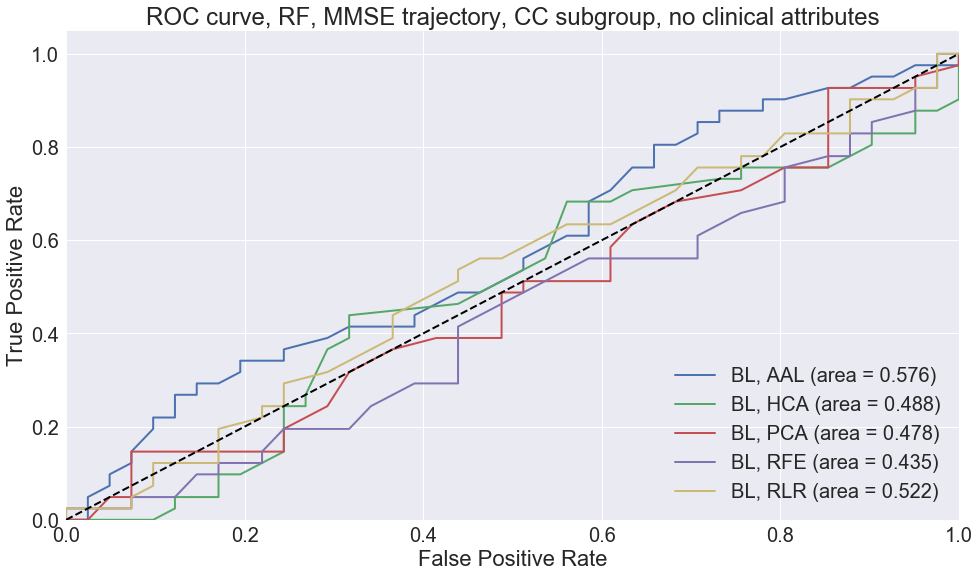

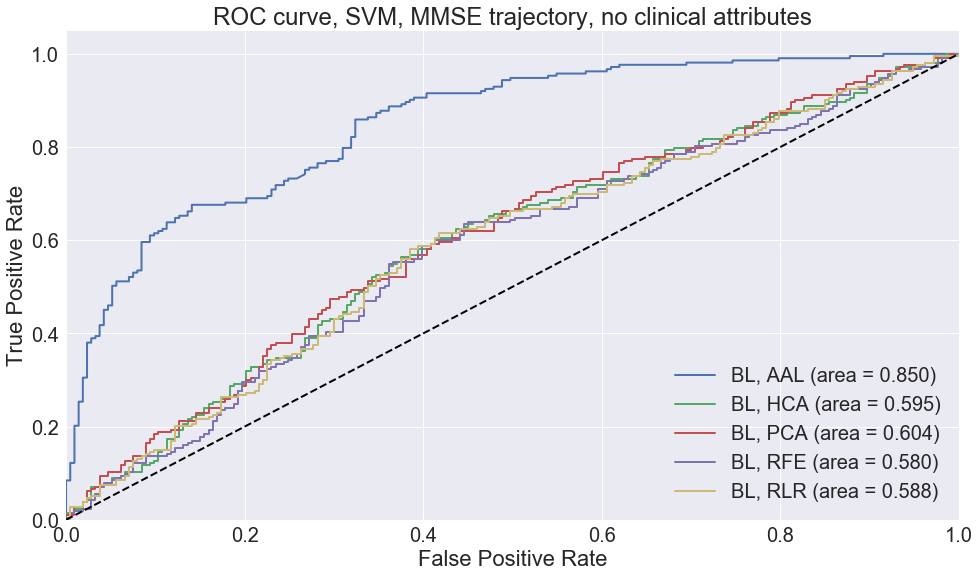

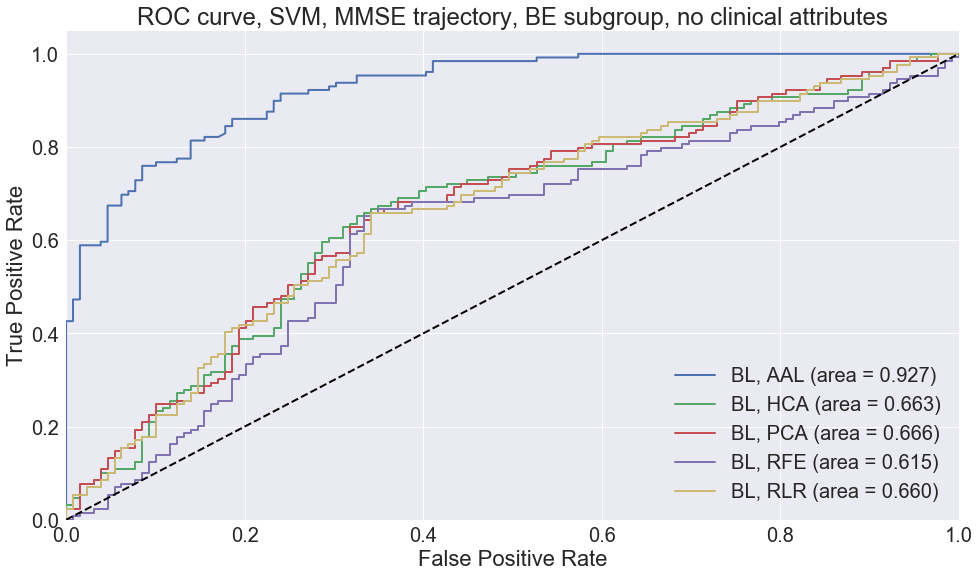

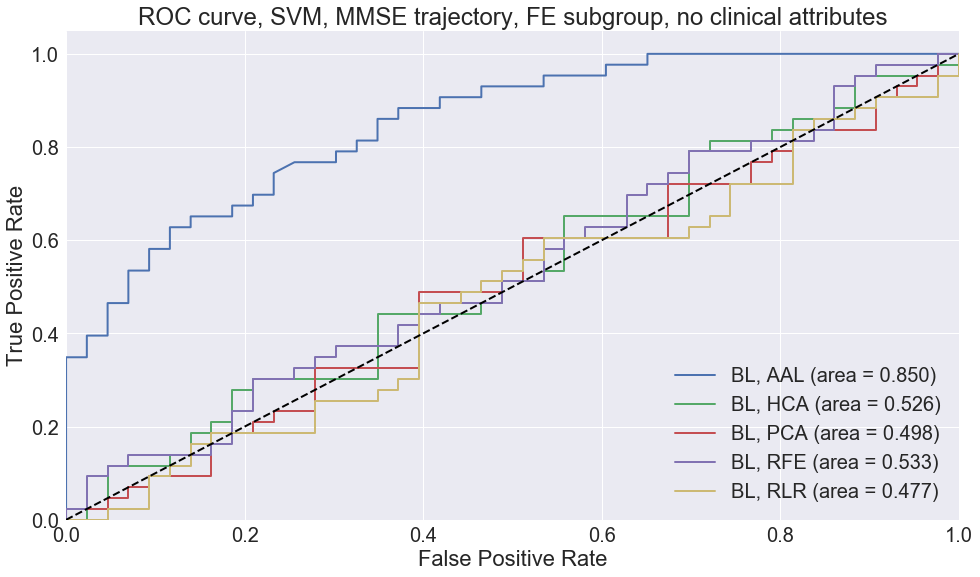

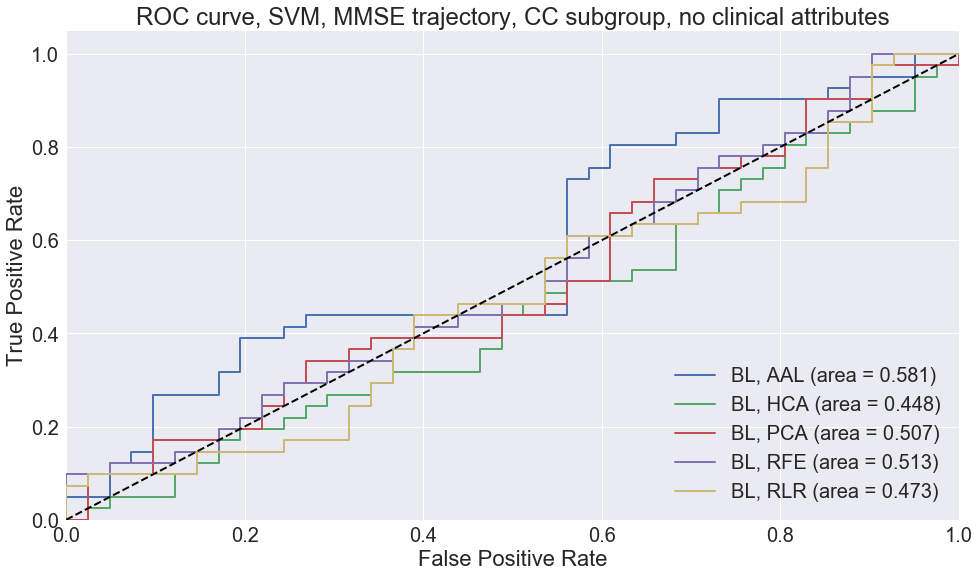

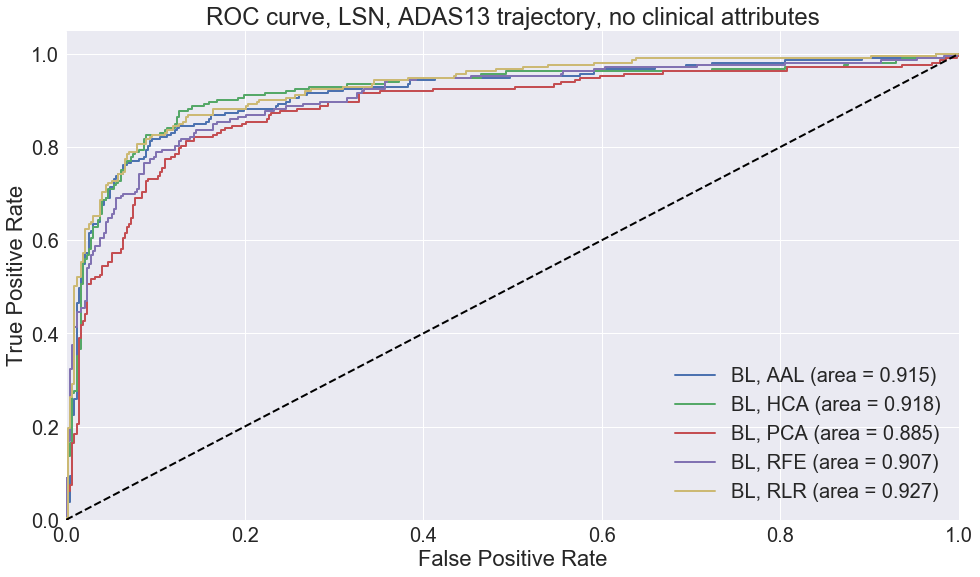

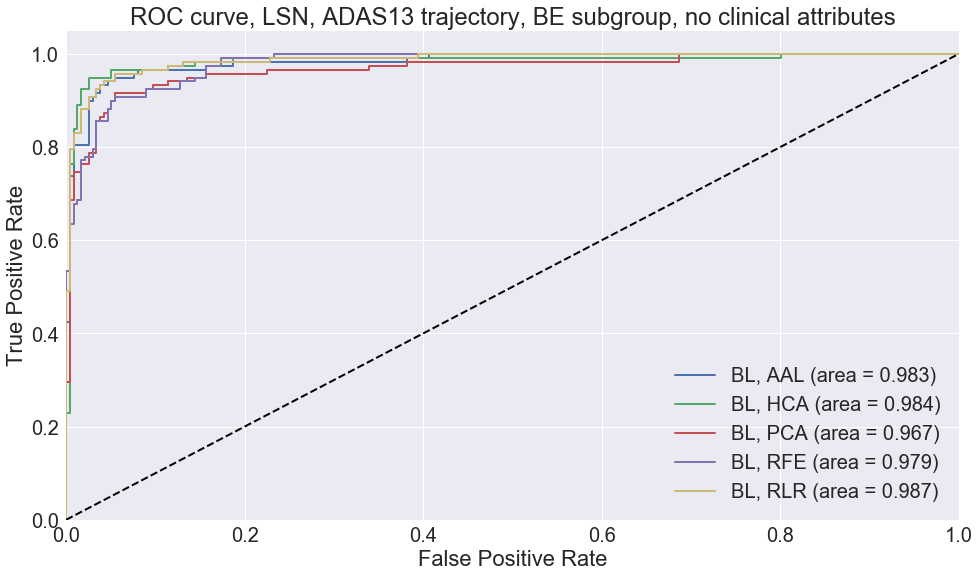

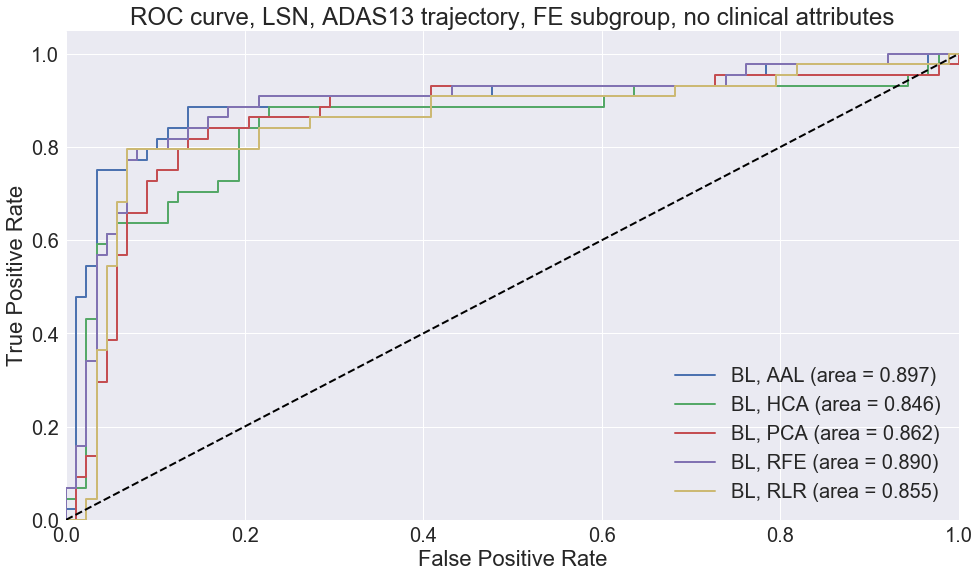

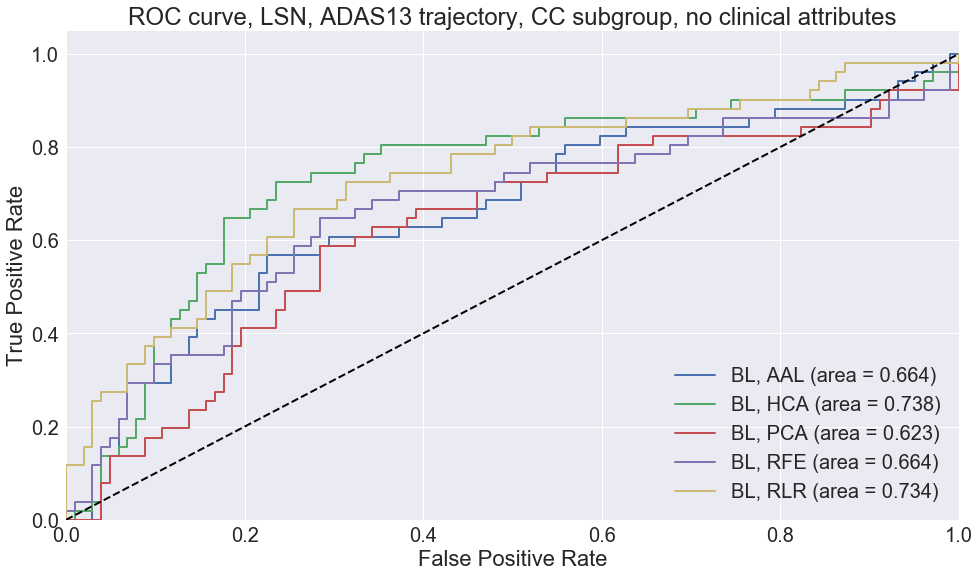

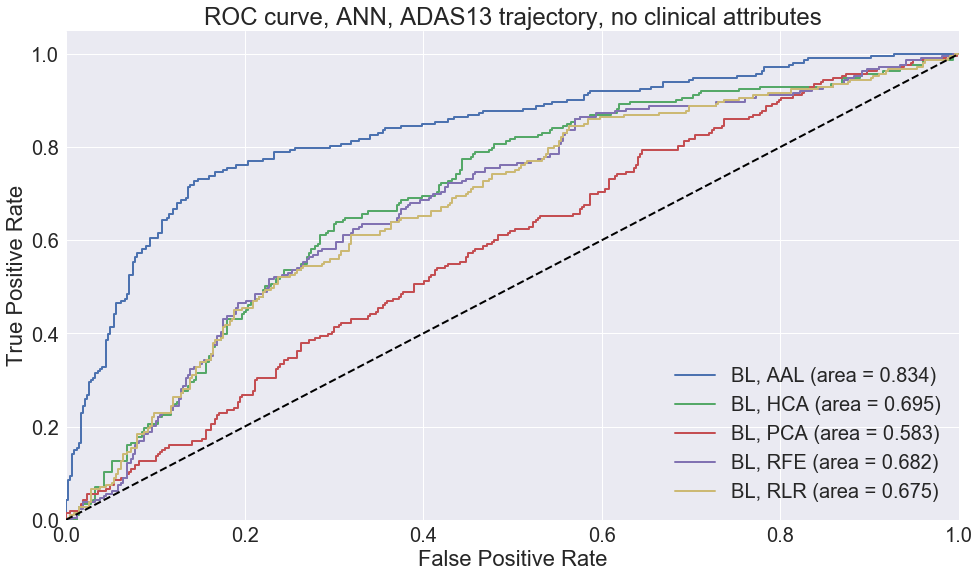

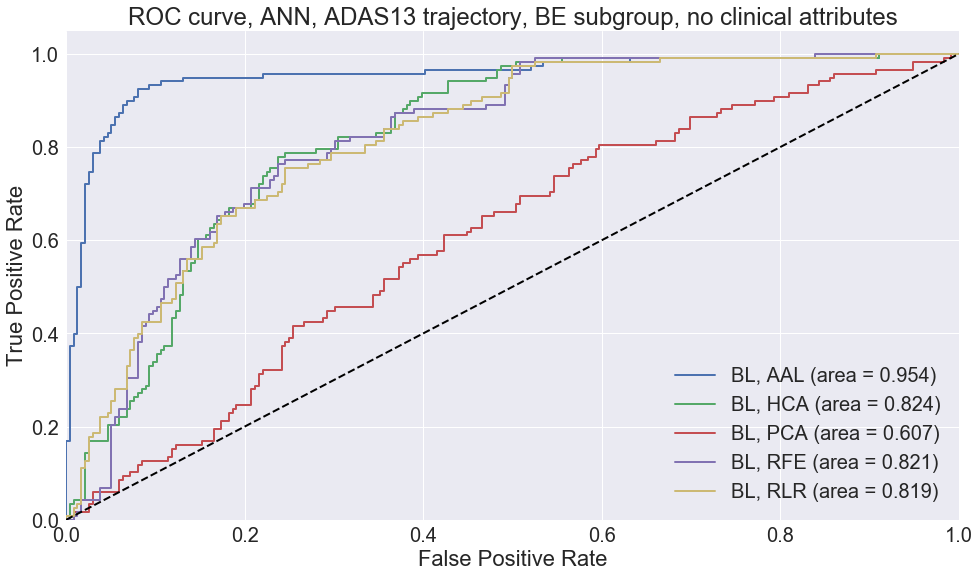

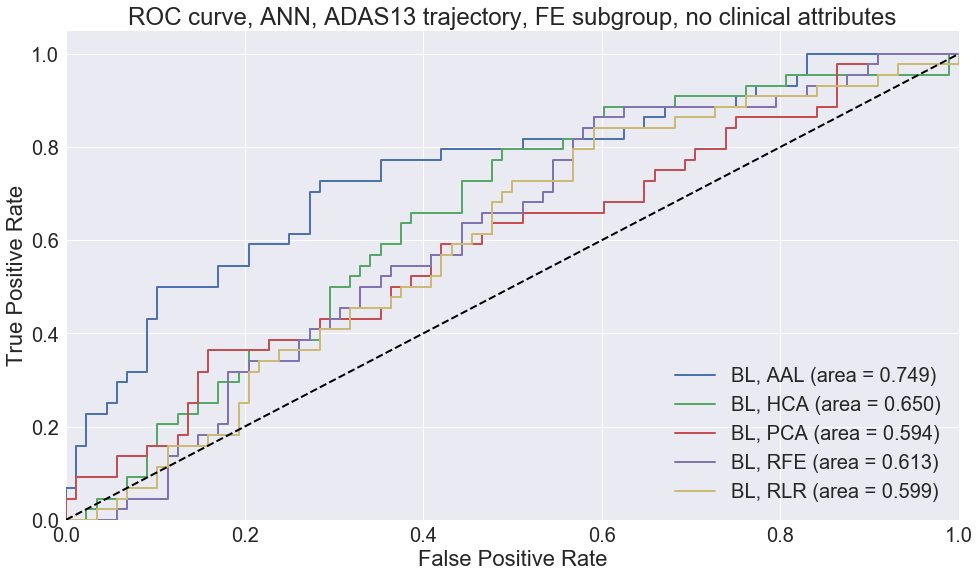

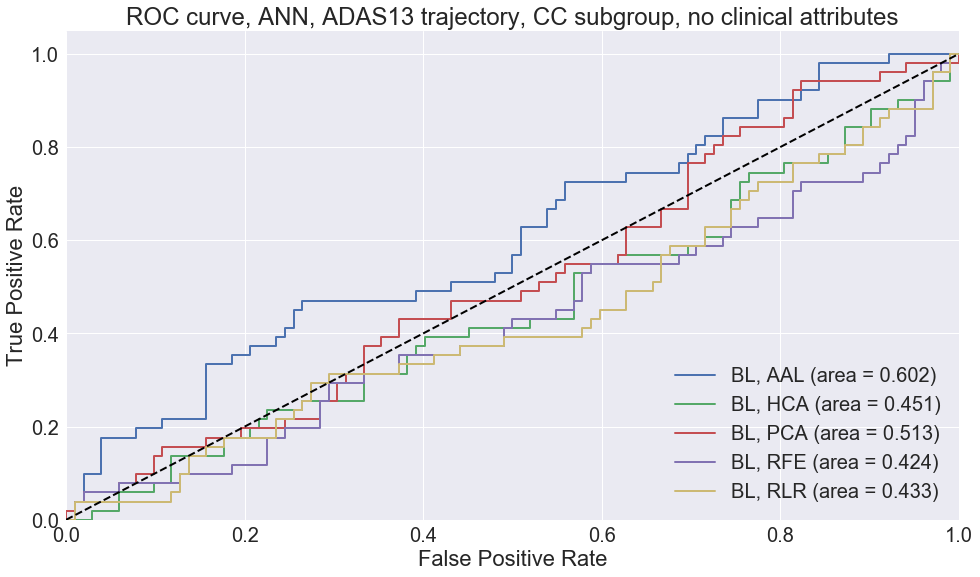

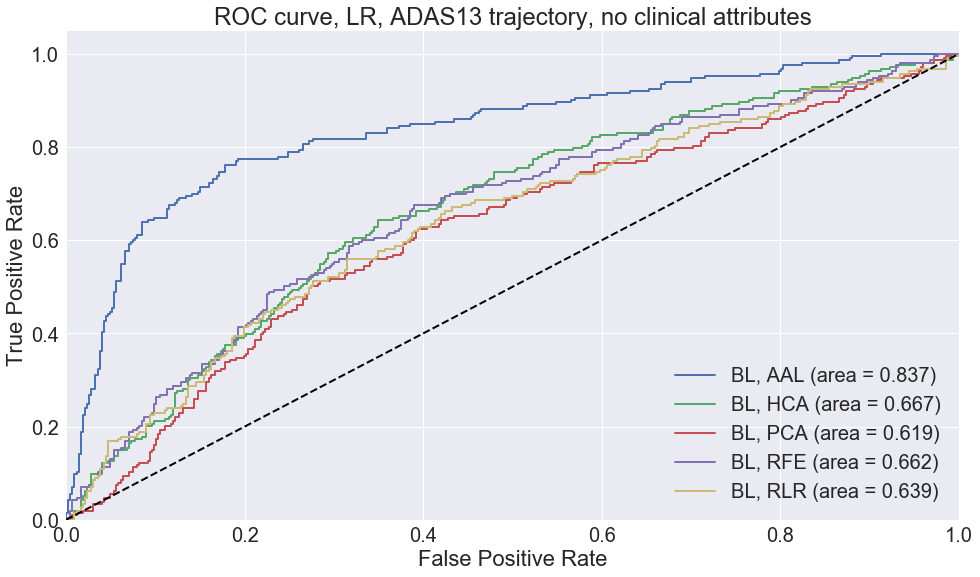

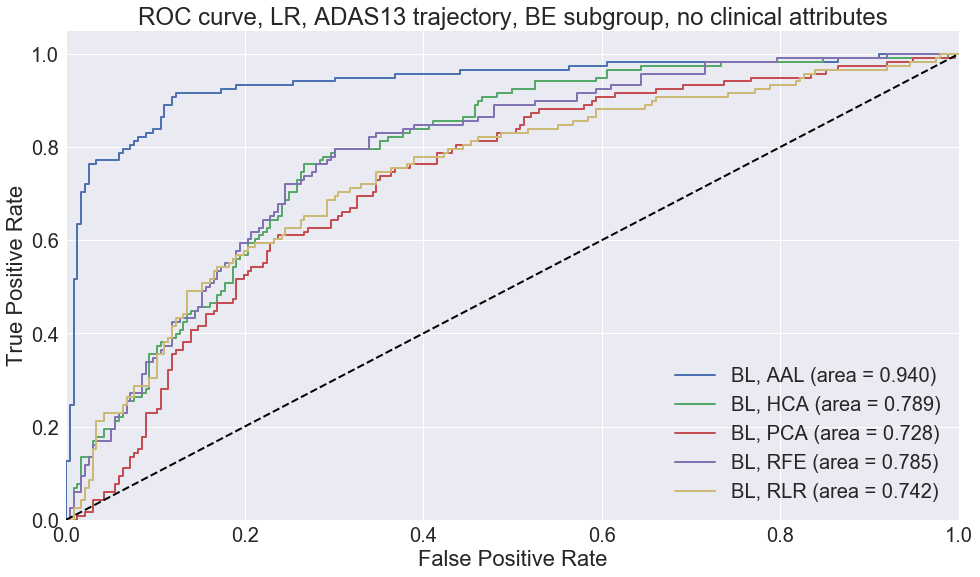

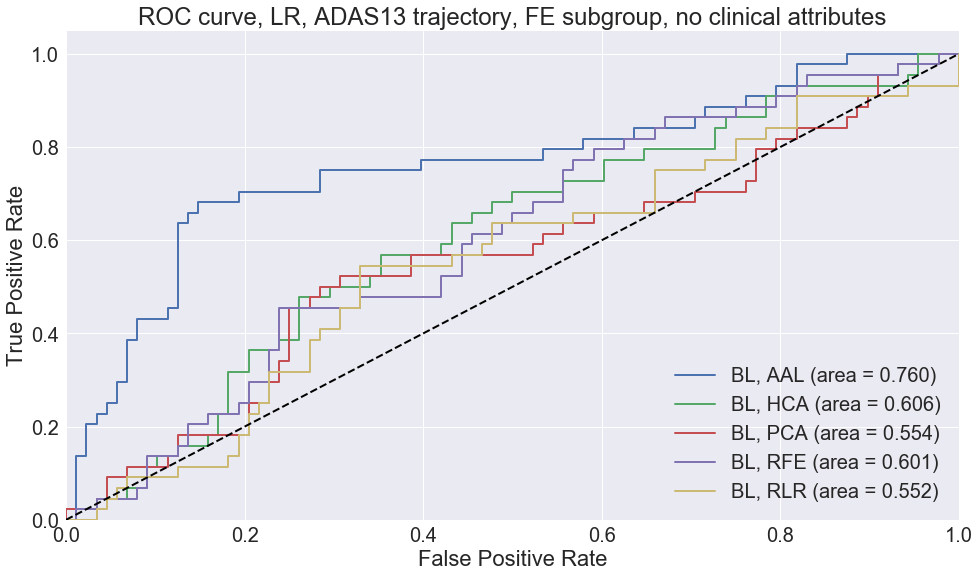

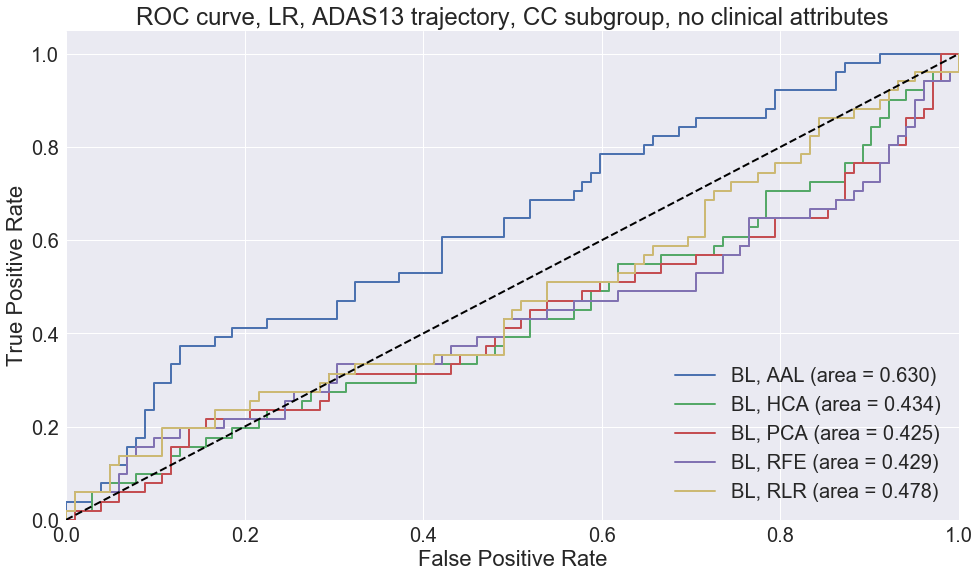

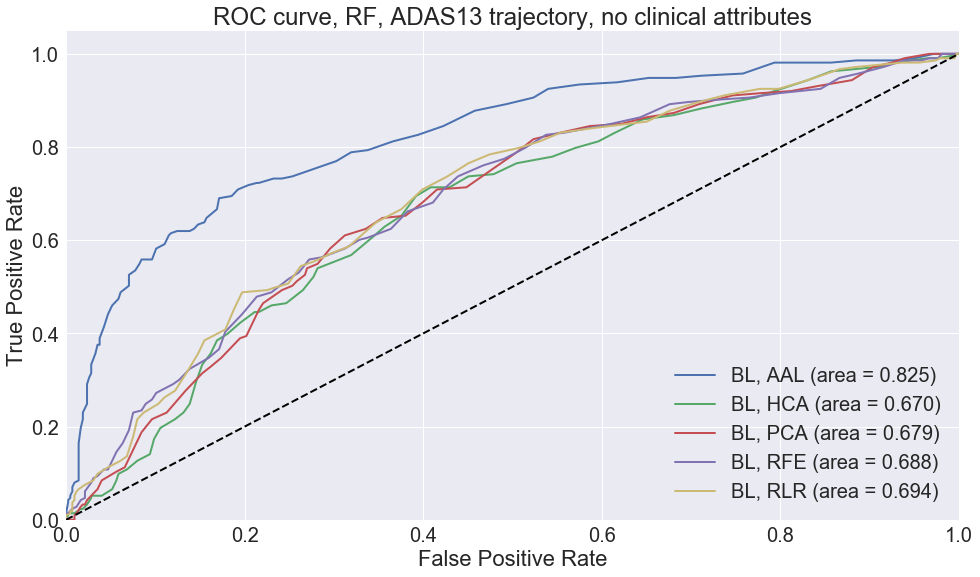

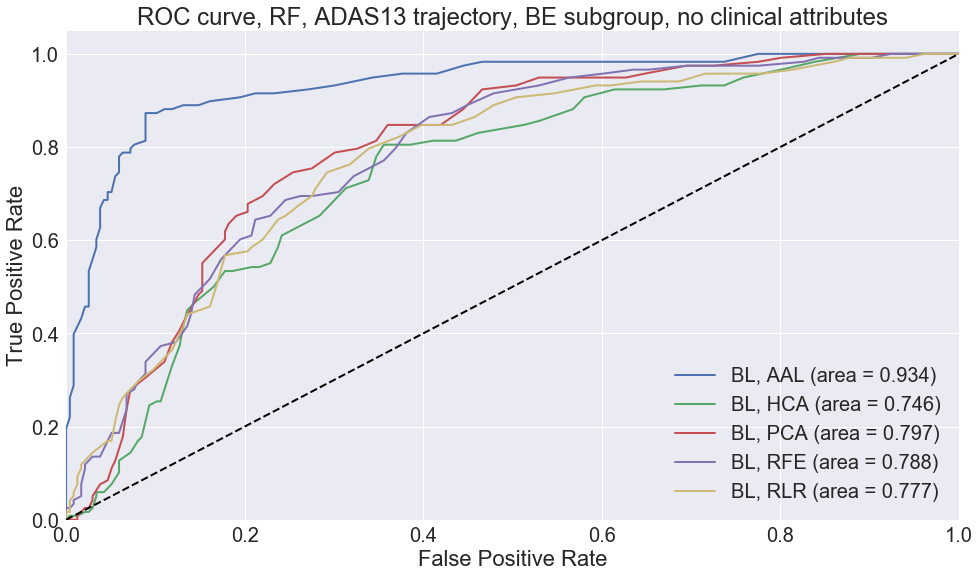

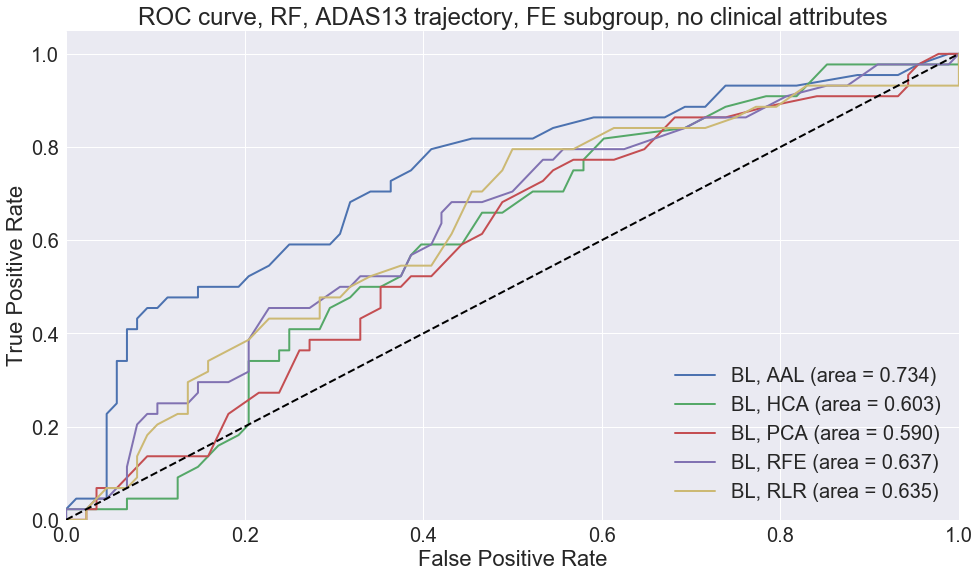

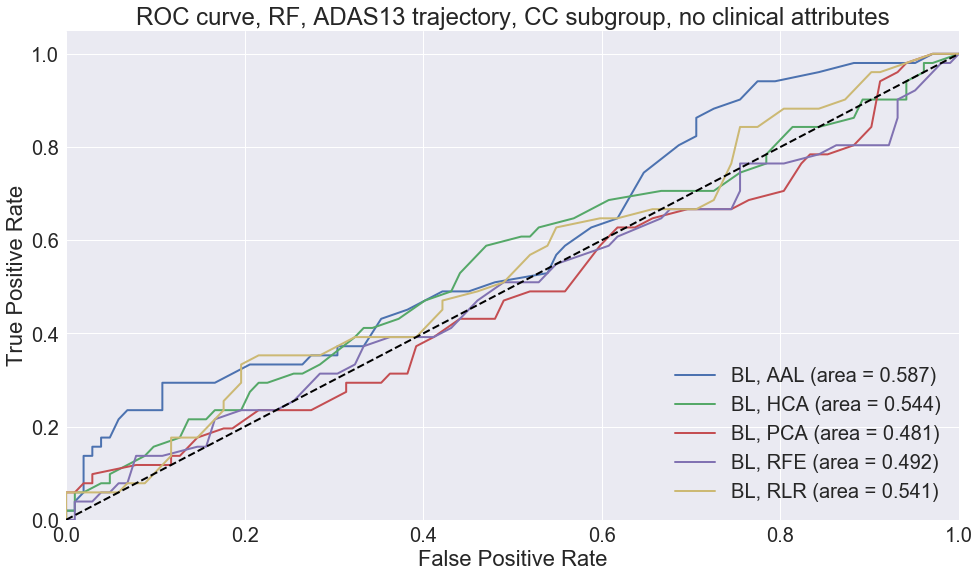

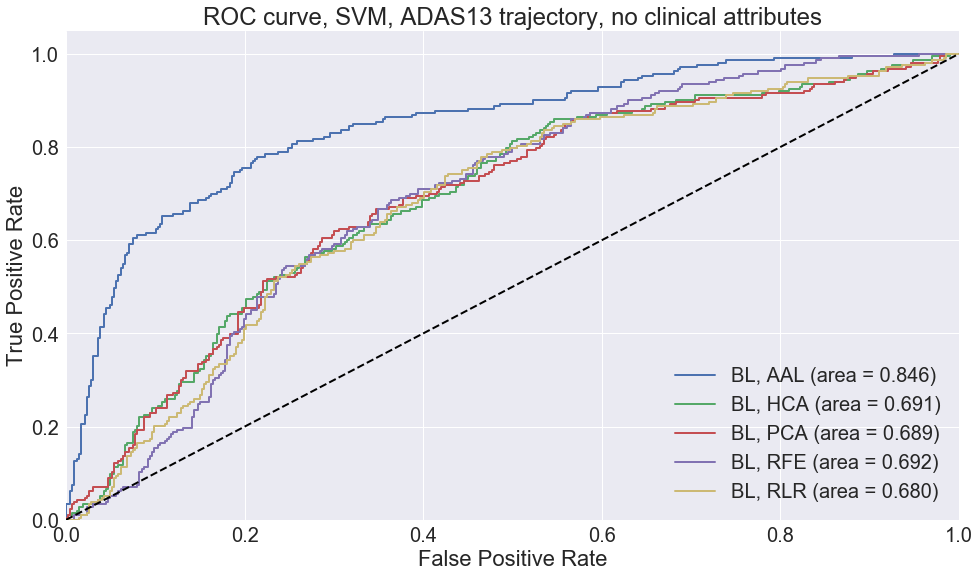

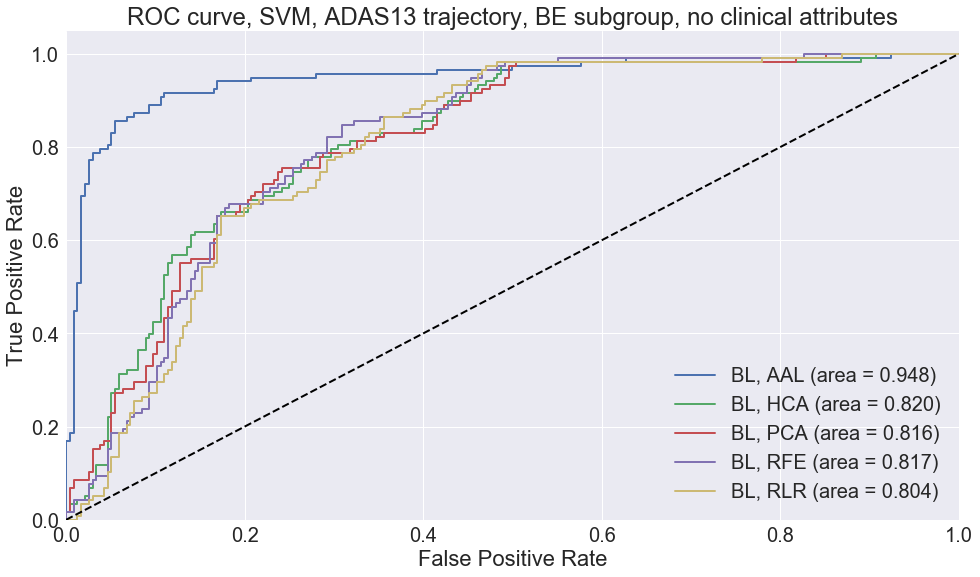

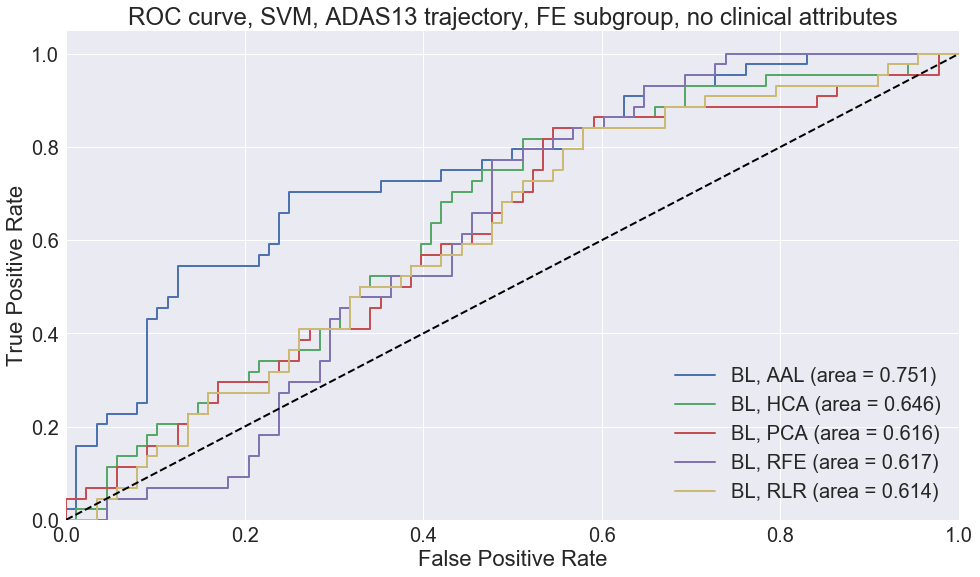

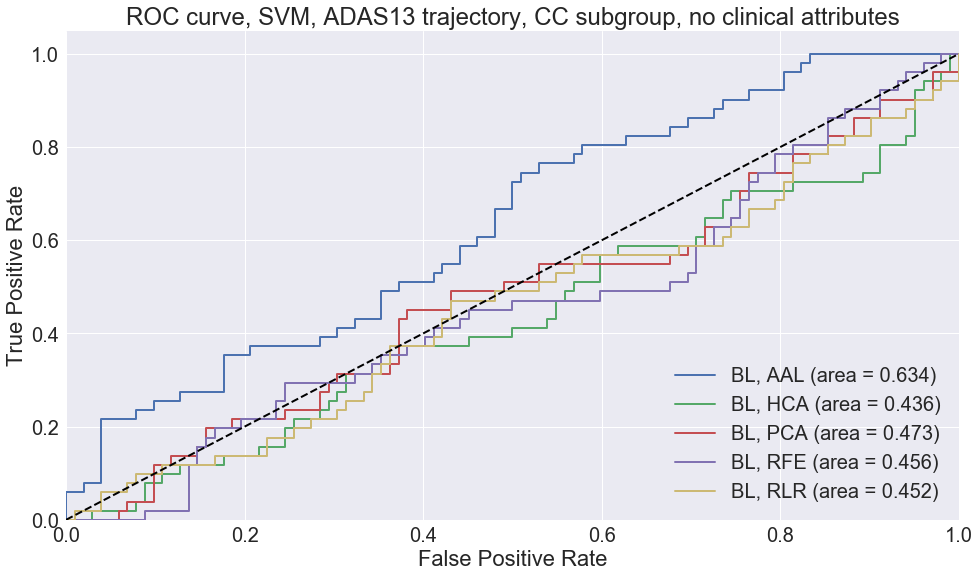

In [25]:
# Plot the Receiver Operator Characteristic curves

for t in ["MMSE", "ADAS13"]:
    for m in ["LSN", "ANN", "LR", "RF", "SVM"]:
        
        roc_stats = {}
        for filename in glob.glob("results/{}*{}*roc_stats.pkl".format(m, t)):
            ftype = filename.split("_")[1]
            with open(filename, "rb") as f:
                roc_stats[ftype] = pkl.load(f)
                
        plt.figure(figsize=(16,9))
        for ftype in ["AAL", "HCA", "PCA", "RFE", "RLR"]:
            plt.plot(roc_stats[ftype]['fpr'], roc_stats[ftype]['tpr'],
                    lw=2, label="BL, {} (area = {:0.3f})".format(ftype, 
                    auc(roc_stats[ftype]['fpr'], roc_stats[ftype]['tpr'])))
    
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curve, {}, {} trajectory, no clinical attributes'.format(m, t))
        plt.legend(loc="lower right")
        plt.savefig("../plots/Exp_Feb26/{}_{}_ROC_curve.png".format(m, t))
        
        for sg in ["BE", "FE", "CC"]:
            plt.figure(figsize=(16,9))
            for ftype in ["AAL", "HCA", "PCA", "RFE", "RLR"]:
                plt.plot(roc_stats[ftype]['fpr_{}'.format(sg)], roc_stats[ftype]['tpr_{}'.format(sg)],
                        lw=2, label="BL, {} (area = {:0.3f})".format(ftype, 
                        auc(roc_stats[ftype]['fpr_{}'.format(sg)], roc_stats[ftype]['tpr_{}'.format(sg)])))

            plt.plot([0, 1], [0, 1], 'k--', lw=2)
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC curve, {}, {} trajectory, {} subgroup, no clinical attributes'.format(m, t, sg))
            plt.legend(loc="lower right")
            plt.savefig("../plots/Exp_Feb26/{}_{}_{}_ROC_curve.png".format(m, t, sg))
